### Import Libraries

In [27]:
# Libraries for data processing and math 
import pandas as pd
import numpy as np

# Library for causal estimation 
import dowhy
from dowhy import CausalModel
import econml
from sklearn.preprocessing import MinMaxScaler

# Library for file path manipulation 
import os

# Set seed to control randomness
np.random.seed(156)

### Read Data

In [34]:
# Load the data and train the XGBoost models
root = os.path.dirname(os.getcwd())
data_dir = os.path.join(root, 'data')
### Cluster 1 Overall ###
c1_overall_path = os.path.join(data_dir, 'time_cluster_1.csv')
c1_overall = pd.read_csv(c1_overall_path)
all_vars = ['days', 'ACTV', 'TEMP', 'HUM', 'WSPD', 'PRES', 'NO2', 'O3', 'PM2.5', 'PM10', 'SO2', 'CO', 'Case']
cluster1_df = c1_overall[all_vars]
# Normalize the data 
scaler = MinMaxScaler()
normalized = scaler.fit_transform(cluster1_df.values)
cluster1_df_norm = pd.DataFrame(normalized)
cluster1_df_norm.columns = cluster1_df.columns
cluster1_df_norm.head()

,days,ACTV,TEMP,HUM,WSPD,PRES,NO2,O3,PM2.5,PM10,SO2,CO,Case
0,0.000000,0.570104,0.502793,0.993318,0.000000,0.869388,0.910256,0.425481,0.382456,0.240291,0.310345,0.491803,0.000000
1,0.012987,0.509862,0.477654,1.000000,0.000000,0.869388,0.717949,0.414663,0.266667,0.156553,0.258621,0.368852,0.063063
2,0.025974,0.441704,0.469274,0.997773,0.062016,0.889796,0.589744,0.485577,0.245614,0.203883,0.275862,0.327869,0.099099
3,0.038961,0.312268,0.446927,0.979955,0.062016,0.922449,0.371795,0.485577,0.133333,0.131068,0.241379,0.213115,0.216216
4,0.051948,0.213670,0.430168,0.975501,0.124031,0.938776,0.262821,0.512019,0.101754,0.128641,0.275862,0.196721,0.216216


### Causal Estimation for Cluster 1 Time Series (Treatment = ```TEMP```)

#### Step 1) Setting up the Causal Graph


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.


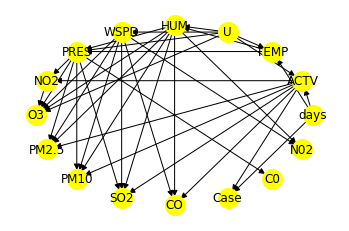

In [25]:
causal_graph = """
digraph {
days; 
ACTV; 
TEMP; 
U[label="Unobserved Confounders"];
HUM; 
WSPD; 
PRES; 
NO2; 
O3; 
PM2.5; 
PM10; 
SO2; 
CO; 
Case; 
days->ACTV; days->TEMP; days->Case; 
U->ACTV; U->TEMP; U->PRES; U->O3; U->HUM; U->WSPD; 
ACTV->NO2; ACTV->Case; ACTV->PM2.5; ACTV->PM10; ACTV->SO2; ACTV->CO; 
PRES->NO2; PRES->O3; PRES->PM2.5; PRES->PM10; PRES->SO2; PRES->C0; 
TEMP->PRES; TEMP->HUM; 
HUM->PRES; HUM->N02; HUM->O3; HUM->PM2.5; HUM->PM10; HUM->SO2; HUM->CO;
WSPD->N02; WSPD->O3; WSPD->PM2.5; WSPD->PM10; WSPD->SO2; WSPD->CO; 
NO2->O3; 
}
"""
from IPython.display import Image, display
model= CausalModel(
        data=cluster1_df,
        graph=causal_graph.replace("\n", " "),
        treatment='PRES',
        outcome='Case')
model.view_model()

#### Step 2) Estimate ATE

In [23]:
def causal_estimate(treatment, data, outcome, causal_graph):
    inspect_datasets = True
    inspect_models = True
    inspect_identified_estimands = True
    inspect_estimates = True
    inspect_refutations = True
    dowhy.causal_refuter.CausalRefuter.DEFAULT_NUM_SIMULATIONS = 100
    dataset = data
    causal_graph = causal_graph
    model = dowhy.CausalModel(data = dataset,
                        treatment = treatment,
                        outcome = outcome,
                        graph = causal_graph.replace("\n", " "))
    print("####### Model #############################################################################################")
    print("Common Causes:",model._common_causes)
    print("Effect Modifiers:",model._effect_modifiers)
    print("Instruments:",model._instruments)
    print("Outcome:",model._outcome)
    print("Treatment:",model._treatment)
    print("#############################################################################################################")
    estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("####### Identified Estimand #####################################################################################")
    print(estimand)
    print("###################################################################################################################")
    estimate_li = model.estimate_effect(estimand,method_name = "backdoor.linear_regression", method_params = None)
    estimate_forest = model.estimate_effect(estimand,method_name ="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                            method_params = {"init_params":{"n_jobs":-1},"fit_params":{}})
    #Linear Results
    print("####### Linear Estimate ################################################################################")
    print("*** Class Name ***")
    print(estimate_li.params['estimator_class'])
    print("*** Treatment Name ***")
    print(model._treatment)
    print(estimate_li)
    print("########################################################################################################")
    #Forest Results
    print("####### Forest Estimate#################################################################################")
    print("*** Class Name ***")
    print(estimate_forest.params['estimator_class'])
    print("*** Treatment Name ***")
    print(model._treatment)
    print(estimate_forest)
    print("########################################################################################################")

In [35]:
causal_estimate(treatment='PRES', data=cluster1_df_norm, outcome='Case', causal_graph=causal_graph)

####### Model #############################################################################################
Common Causes: ['U', 'days']
Effect Modifiers: ['ACTV']
Instruments: []
Outcome: ['Case']
Treatment: ['PRES']
#############################################################################################################
####### Identified Estimand #####################################################################################
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                 
───────(Expectation(Case|CO,days,ACTV,WSPD,TEMP,HUM))
d[PRES]                                              
Estimand assumption 1, Unconfoundedness: If U→{PRES} and U→Case then P(Case|PRES,CO,days,ACTV,WSPD,TEMP,HUM,U) = P(Case|PRES,CO,days,ACTV,WSPD,TEMP,HUM)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(

The econml.ortho_forest.ContinuousTreatmentOrthoForest class has been renamed to econml.orf.DMLOrthoForest; an upcoming release will remove support for the old name
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   32.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 

####### Linear Estimate ################################################################################
*** Class Name ***
<class 'dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator'>
*** Treatment Name ***
['PRES']
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                 
───────(Expectation(Case|CO,days,ACTV,WSPD,TEMP,HUM))
d[PRES]                                              
Estimand assumption 1, Unconfoundedness: If U→{PRES} and U→Case then P(Case|PRES,CO,days,ACTV,WSPD,TEMP,HUM,U) = P(Case|PRES,CO,days,ACTV,WSPD,TEMP,HUM)

## Realized estimand
b: Case~PRES+CO+days+ACTV+WSPD+TEMP+HUM+PRES*ACTV
Target units: ate

## Estimate
Mean value: 0.07008893758689778
### Conditional Estimates
__categorical__ACTV
(-0.001, 0.166]    0.086774
(0.166, 0.319]     0.079717
(0.319, 0.477]     0.070445
(0.477, 0.634]     0.062457
(0.6

[Parallel(n_jobs=-1)]: Done 546 out of 546 | elapsed:   34.0s finished
